#Anomaly Detection 

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
import warnings
warnings.filterwarnings("ignore")

# Outline

## Anomaly Detection
- 3 Sigma Law
- Distance-based
- DBSCAN
- One-class SVM
- Isolation Forest



## Data preparation & EDA

In [30]:
data = pd.read_csv('winequality-white.csv', sep=';')

In [31]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [32]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


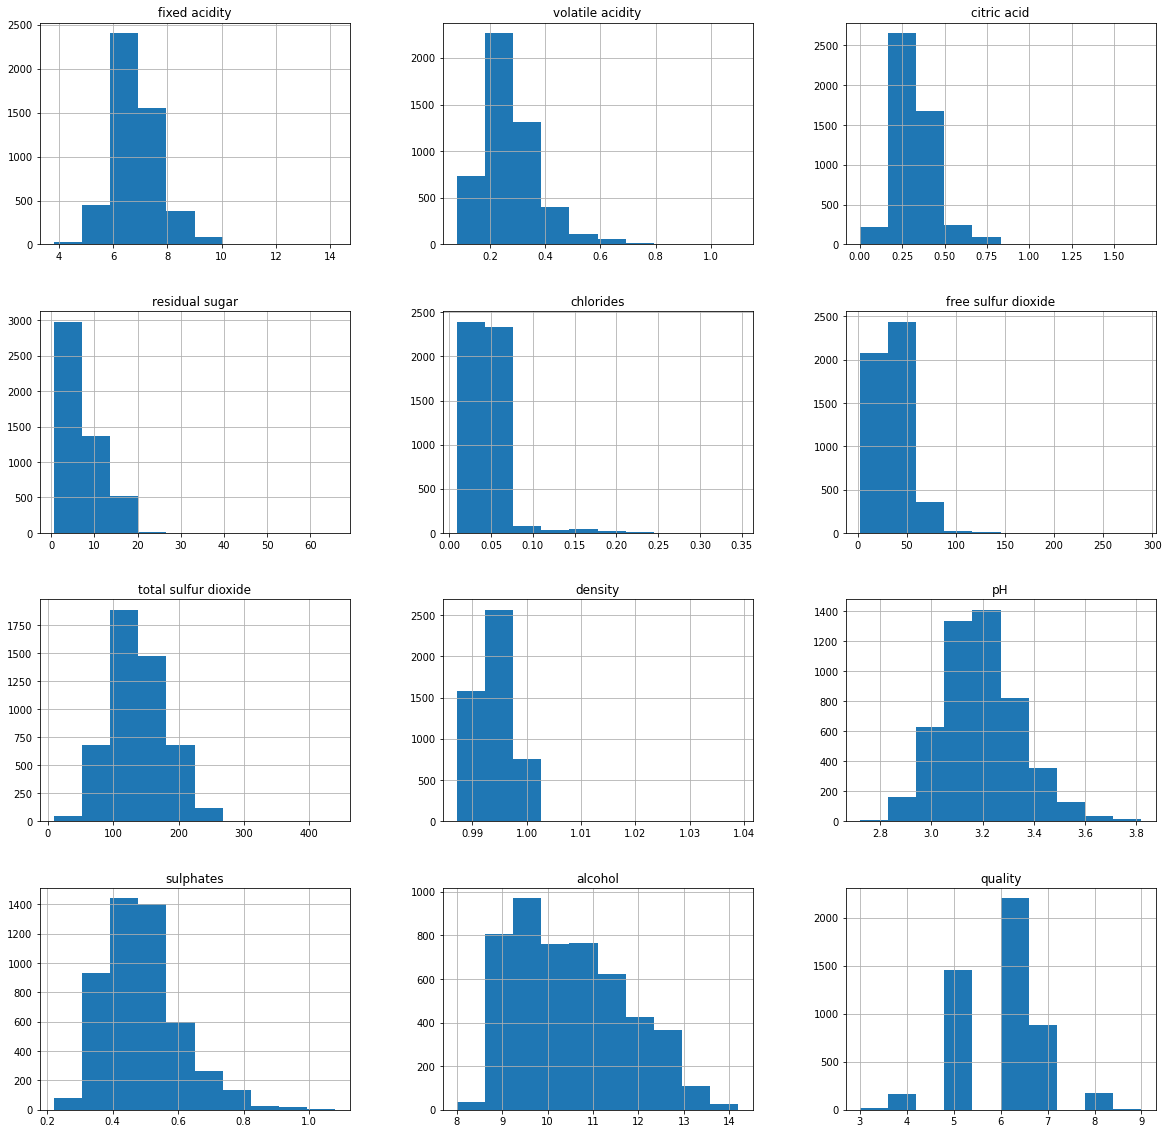

In [34]:
data.hist(figsize=(20, 20));

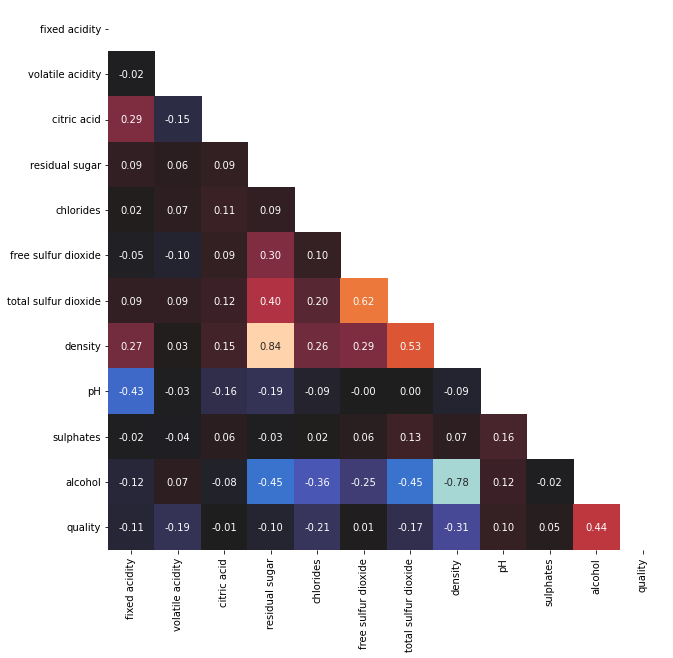

In [35]:
plt.figure(figsize=(10,10))

corr_matrix = data.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [36]:
high_corr = [
    column for column in lower.columns if any((lower[column] > 0.6)|(lower[column] < -0.6))
]
high_corr

['residual sugar', 'free sulfur dioxide', 'density']

In [37]:
other_features = [col for col in data.columns if col not in high_corr and col!='quality']

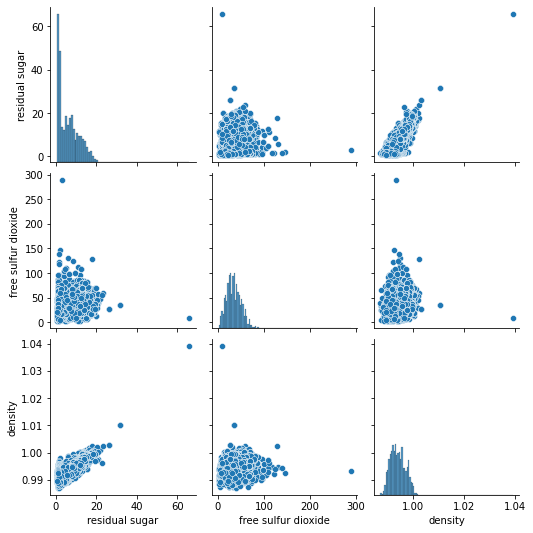

In [38]:
sns.pairplot(data[high_corr]);

## The Simple method

### 3-$\sigma$

In [39]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [40]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [41]:
data_features = data.iloc[:, :-1]

In [42]:
comparison_table, std_outliers = get_column_outliers(data_features)
anomalies_report(std_outliers)

Total number of outliers: 396
Percentage of outliers:   8.08%


In [43]:
comparison_table

,upper_bound,lower_bound,anomalies_count,anomalies_percentage
chlorides,0.111316,-0.019772,102.0,2.082483
citric acid,0.697251,-0.028868,85.0,1.735402
volatile acidity,0.580625,-0.024143,81.0,1.653736
sulphates,0.832224,0.147469,48.0,0.979992
fixed acidity,9.386392,4.323183,46.0,0.939159
free sulfur dioxide,86.329497,-15.713327,32.0,0.653328
pH,3.641268,2.735265,32.0,0.653328
total sulfur dioxide,265.854851,10.866464,12.0,0.244998
residual sugar,21.607588,-8.824758,9.0,0.183748
density,1.003000,0.985055,3.0,0.061249


## Distance-based

In [44]:
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler

class DistanceOutliers(BaseEstimator):
    """
    -----------
    Parameters:
    
    - metric: string, default - euclidean
        metric to use for distance calculation (see scipy.spatial.distance.cdist)
        
    - percentile: float in range [0, 100]
        hyperparameter which sets the threshold for anomalies
    """
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [45]:
scaler = RobustScaler()
scaled_data = pd.DataFrame(
    data=scaler.fit_transform(data_features), 
    columns=data_features.columns
)

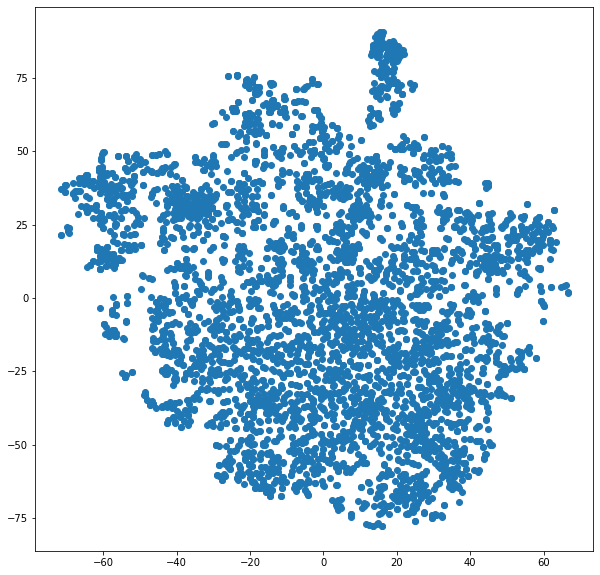

In [46]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50, n_jobs=-1)
tsne_transformed = tsne.fit_transform(scaled_data)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1]);

In [47]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=95)
euclidian_model.fit(scaled_data)
euclidian_outliers = euclidian_model.predict(scaled_data)
anomalies_report(euclidian_outliers)

Total number of outliers: 244
Percentage of outliers:   4.98%


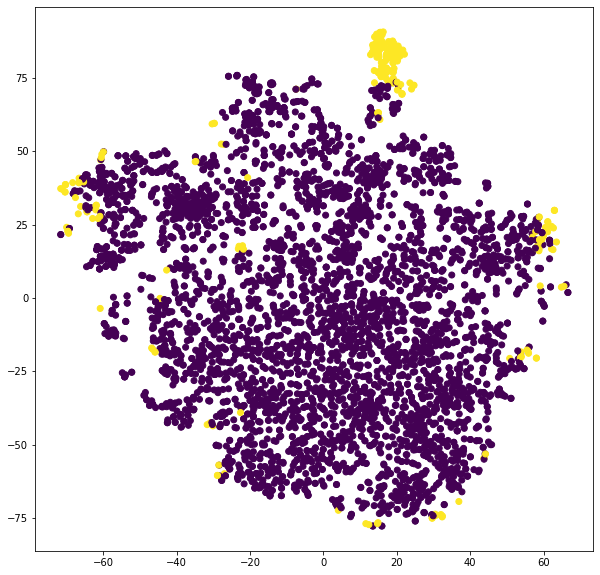

In [48]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=euclidian_outliers);

In [49]:
citiblock_model = DistanceOutliers(metric='cityblock', percentile=95)
citiblock_model.fit(scaled_data)
cityblock_outliers = citiblock_model.predict(scaled_data)
anomalies_report(cityblock_outliers)

labeled_data = data_features.copy()
labeled_data['is_outlier'] = cityblock_outliers

Total number of outliers: 245
Percentage of outliers:   5.00%


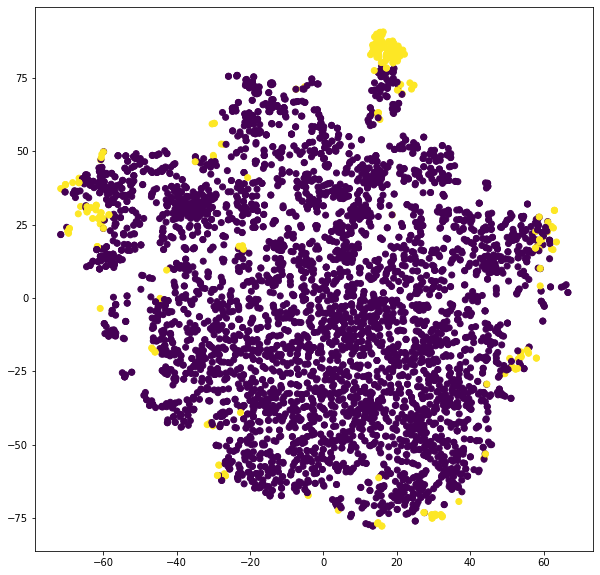

In [50]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne_transformed[:, 0], tsne_transformed[:, 1], c=cityblock_outliers);

## DBSCAN

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/


<img src="https://upload.wikimedia.org/wikipedia/commons/a/af/DBSCAN-Illustration.svg" width=500>

In [51]:
from sklearn.cluster import DBSCAN

# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 0.05
eps_history = [eps]
while outlier_percentage>0.1:    
    model = DBSCAN(eps=eps).fit(scaled_data)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    
model = DBSCAN(eps)
model.fit(scaled_data)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])

In [52]:
eps

1.5500000000000007

In [53]:
anomalies_report(density_outlier)

Total number of outliers: 381
Percentage of outliers:   7.78%


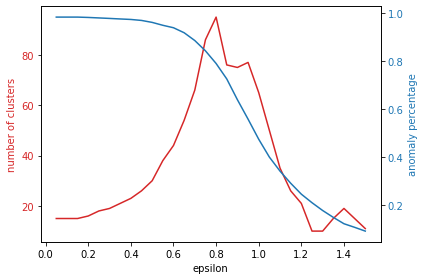

In [54]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('anomaly percentage', color=color)  
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

# Anomaly Detection with sklearn


`Scikit-learn` has several anomalies detection algorithms. Their description and examples are provided on [this page](https://scikit-learn.org/stable/modules/outlier_detection.html).



## One-class SVM <a id="one-class_svm"></a>

# <center>Unsupervised model-based</center>

## <center>One-Class SVM</center>

## Brielfy about Support Vector Machine

In short, the SVM is a basic linear model. The main idea of the algorithm (in the case of classification) is to divide the classes by a hyperplane so as to maximize the distance (gap) between them. Initially, the algorithm was able to work only with linearly separable classes, but in the 90s of the last century, the method became especially popular due to the introduction of the "Kernel Trick" (1992), which made it possible to work effectively with linearly inseparable data.

![](https://sandipanweb.files.wordpress.com/2018/04/svm_slack.png?w=676)

## Kernel Trick

The kernel is a function that can transform the feature space (including non-linearly), without directly transforming the features.

It is extremely efficient in terms of calculation and potentially allows you to obtain infinite-dimensional feature spaces.

The idea is that classes that are linearly inseparable in the current feature space can become separable in higher-dimensional spaces:

![](https://miro.medium.com/max/1838/1*eU9PzjVcLNbNEzBC2g_iWg.jpeg)

## One Class SVM
http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

**One Class SVM** - this is one of the forms of the classical algorithm, but, as the name implies, to train it, we only need to have one class, even if it is a little "noisy", and we want to learn how to make a decision for each new observation, whether it is anomalous or not.

**General Idea:** transform the feature space and draw the separating hyperplane so that the observations lie as far away from the origin as possible:



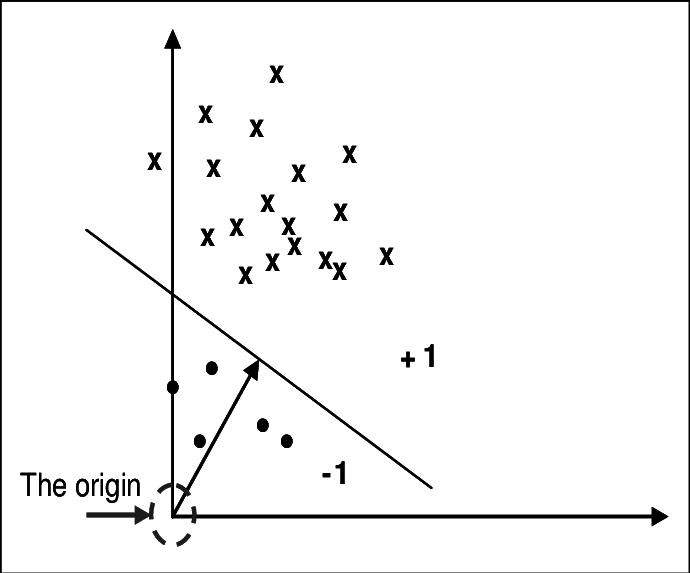

As a result, we get a boundary on one side of which lie the most "dense" and similar observations from our training sample, and on the other side there will be anomalous values that are not similar to all the others. The percentage of such anomalous observations that the model will try to separate from the main part of the sample, we again set at the very beginning of training using the parameter `nu`

In [55]:
from sklearn.svm import OneClassSVM

one_class_svm = OneClassSVM(nu=0.10, gamma='auto')
one_class_svm.fit(scaled_data)
svm_outliers = one_class_svm.predict(scaled_data)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

In [56]:
anomalies_report(svm_outliers)

Total number of outliers: 499
Percentage of outliers:   10.19%


## Pros and cons

\+ Due to kernel trick, the model is able to draw **non-linear dividing boundaries**

\+ It is especially convenient to use when there are not enough "bad" observations in the data to use the standard approach of teaching with a teacher - binary classification

\- It can be very **over-trained** and produce a large number of false negative results if the separation gap is too small

## Isolation Forest <a id="isolation_forest"></a>

## <center> Isolation Forest </center>

The idea - let's see how easy it is to "isolate" an observation from everyone else. If it is too easy, it probably lies far away and is an outlier. If it is very heavy - most likely it is similar to a bunch of other points and is not an outlier.


**Algorithm:**
1. Select the point to isolate.
2. For each feature, set the isolation range between minimum and maximum.
3. Select a feature at random.
4. Select a value that is in the range, again randomly:
    - If the point is higher than the selected value, move the minimum range of the feature by this value.
    - If the point is lower, move the maximum value of the feature by the value.
5. Repeat steps 3 and 4 until the point is isolated. That is, until the point becomes the only one located within the range for all the features.
6. Count the number of times you had to repeat steps 3 and 4.

https://quantdare.com/isolation-forest-algorithm/

In [57]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, 
                                   max_features=1.0, bootstrap=True)
isolation_forest.fit(scaled_data)

isolation_outliers = isolation_forest.predict(scaled_data)
isolation_outliers = np.array([1 if label == -1 else 0 for label in isolation_outliers])

In [58]:
anomalies_report(isolation_outliers)

Total number of outliers: 490
Percentage of outliers:   10.00%


## Pros and cons

\+ Again **non-linear separating boundaries**, intuitive working principles

\+ Again, it is convenient to use when we can not enter the binary classification

\- A rather complex parameter setting, which is difficult to carry out without at least a minimal markup or an assumption about the number of "dirty" observations-the `contamination`parameter

# All combined

In [59]:
summary = np.concatenate((
    [std_outliers], 
    [euclidian_outliers], 
    [cityblock_outliers],
    [density_outlier],
    [svm_outliers],
    [isolation_outliers]
))

In [60]:
summary = pd.DataFrame(
    summary.T, 
    columns=['std',  'euclid', 'cityblock', 'dbscan', 'svm', 'isolation']
)
summary.head()

,std,euclid,cityblock,dbscan,svm,isolation
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [61]:
summary.sum(axis=1).value_counts()

0    4120
1     254
2     157
6     113
3      93
5      86
4      75
dtype: int64

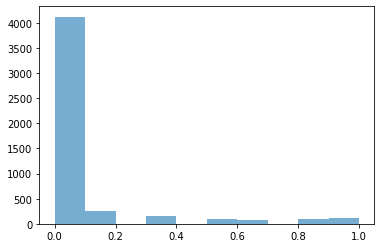

In [62]:
outlier_score = summary.mean(axis=1)
plt.hist(outlier_score, alpha=0.6);